# Ph.D. Course on "Advanced Machine Learning" August 23rd, 2024
## - Physics-Informed Machine Learning and Surrogate Modelling

This notebook is a part of exercises in the PhD Course that complement the lecture. 

To make sure your environment is setup to perform the exercises please visit

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://github.com/apengsigkarup

and follow the instructions for installing the environment.

If you have not already done so, please download all the data files and codes from this github repository and report any errors or issues with the materials to Allan Peter Engsig-Karup (apek@dtu.dk).

### Python modules needed

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import platform
import math
import imageio.v2 as imageio
from IPython.display import clear_output

### Detect device

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Check for ARM architecture
architecture = platform.machine()
if 'arm' in architecture or 'aarch' in architecture:
    print("Architecture: ARM")
else:
    print(f"Architecture: {architecture}")

# Optional: More detailed GPU check
if device == "cuda":
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Check for CPU information
cpu_info = platform.processor()
if cpu_info:
    print(f"CPU: {cpu_info}")
else:
    print("CPU information not available.")


Device: cpu
Architecture: ARM
CPU: arm


### Define Precision used in PyTorch

In [3]:
# Set default tensor type in PyTorch to float64 precision
torch.set_default_dtype(torch.float32)

### Define seed for deterministic (reproducible) calculations while testing

In [4]:
# for reproducibility, define a seed manually
seed = 28 
torch.manual_seed(seed)
#random.seed(seed)
np.random.seed(seed)

## Exercise 01: Solving the Helmholtz equation with FNN

The purpose of this notebook is gain some experiences with setting up physics-informed neural networks for tasks such as
- solving a differential equation
- finding approximate solutions of systems


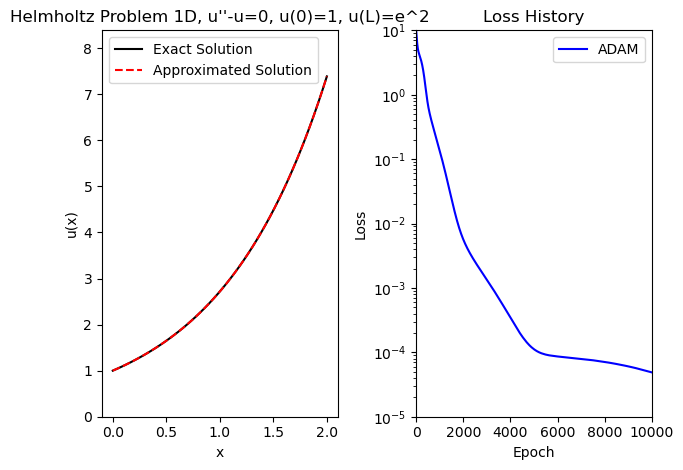

In [10]:
# Optimizer method, 1: L-BFGS, 0: ADAM
OptMethod = 0
if OptMethod:
    OptimizerNAME = 'L-BFGS'
else:
    OptimizerNAME = 'ADAM'

# Constants for the problem
L = 2
c = 1
d = math.exp(2)

c1 = (-c + d*np.exp(L))/(np.exp(2*L) - 1)
c2 = (c*np.exp(2*L) - d*np.exp(L))/(np.exp(2*L) - 1)

# Training nodes, where residual is to be measured
N_training = 10
N_epochs = 10000

# Define the neural network architecture with weight initialization
class BoundaryConditionedNet(nn.Module):
    def __init__(self):
        super(BoundaryConditionedNet, self).__init__()
        <DEFINE THIS>
        self.initialize_weights()        

    def initialize_weights(self):
        # Apply Xavier initialization to each layer
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        # Initialize biases to zero
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, x):
        <DEFINE THIS>
    return x

# Instantiate the network
net = BoundaryConditionedNet()

# Define the optimizer
if OptMethod:
    optimizer = <DEFINE THIS>
else:
    optimizer = <DEFINE THIS>
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Prepare for storing snapshots and loss history
snapshots = []
loss_history = []

x_test = torch.unsqueeze(torch.linspace(0, L, 50), dim=1)
u_exact = c1*np.exp(x_test.numpy()) + c2*np.exp(-x_test.numpy())

# Training loop
for epoch in range(N_epochs+1):

    if OptMethod:
        def closure():
                optimizer.zero_grad()

                # Generate input data points
                x = torch.unsqueeze(torch.linspace(0, L, N_training), dim=1)
                x.requires_grad_(True)
                
                N_x = net(x)
                u = c + (d - c) / L * x + x * (L - x) * N_x

                u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

                residual = u_xx - u
                loss = torch.mean(residual ** 2)
                loss.backward()
                return loss

        optimizer.step(closure)
        lossterm = closure().item()    
    else:
        optimizer.zero_grad()

        # Generate input data points
        x = torch.unsqueeze(torch.linspace(0, L, N_training), dim=1)
        x.requires_grad_(True)
        
        N_x = net(x)
        u = c + (d - c) / L * x + x * (L - x) * N_x

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        residual = <DEFINE THIS>
        loss = torch.mean(residual ** 2)
        loss.backward()
        optimizer.step()
        lossterm = loss.item()

    # Update the learning rate
    #scheduler.step()

    loss_history.append(lossterm)

    if epoch % 100 == 0:
        with torch.no_grad():
            N_x_test = net(x_test)
            u_test = c + (d - c) / L * x_test + x_test * (L - x_test) * N_x_test
            u_test = u_test.numpy()

        # Store snapshot
        plt.figure(figsize=(12, 4))
        
        # Clear the previous output in the cell
        clear_output(wait=True)  

        # Solution approximation subplot
        plt.subplot(1, 2, 1)
        plt.plot(x_test.numpy(), u_exact, 'k', label='Exact Solution')
        plt.plot(x_test.numpy(), u_test, 'r--', label='Approximated Solution')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title(f'Helmholtz Problem 1D, u\'\'-u=0, u(0)=1, u(L)=e^2')
        plt.ylim([0, d+1])
        plt.legend()

        # Loss history subplot
        plt.subplot(1, 2, 2)
        plt.semilogy(range(epoch + 1), loss_history, 'b-',label='%s'%(OptimizerNAME))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.xlim([0, N_epochs])
        plt.ylim([1e-5, 10])
        plt.tight_layout()
        plt.legend()
        plt.show()

